In [2]:
import pandas as pd
from pathlib import Path


In [3]:
def extract_stats(path: Path):
    df = pd.read_json(path, lines=True)

    cols = ["eval_en", "eval_de", "eval_city", "eval_disease"]

    exp_names = df["exp_name"].unique()


    ret = {}

    for exp in exp_names:
        small = df[df["exp_name"] == exp]
        res = {}
        for col in cols:
            res[col] = small[col].mean().item()

        ret[exp] = res
    return ret

In [4]:
baseline_path = Path("/workspace/chunky-experiments/baseline-output-qwen2-7b/results_evaluated.jsonl")
finetuned_path = Path("/workspace/chunky-experiments/experiments/2025-06-22_19-25-13_7B_sen_len_4_opts")

baseline_stats = extract_stats(baseline_path)

# list all folders in finetuned_path

results = {}

results["baseline"] = baseline_stats
finetuned_folders = list(finetuned_path.glob("*"))
for file in finetuned_folders:
    results_path = file / "validation_data" / "results_evaluated.jsonl"
    if results_path.exists():
        finetuned_stats = extract_stats(results_path)
        # find first underscore and remove everything before it
        exp_name = file.name[file.name.find("_") + 1:]
        results[exp_name] = finetuned_stats
       

In [15]:
import numpy as np

agg = {
    "in": {
        "language": [],
        "domain": [],
    },
    "out": {
        "language": [],
        "domain": [],
    }
}

STARTS = {
    "en": "start_en",
    "de": "start_de",
    "city": "city",
    "disease": "disease",
}

EVALS = {
    "en": "eval_en",
    "de": "eval_de",
    "city": "eval_city",
    "disease": "eval_disease",
}

gen = {
    "en": {
        "in": [],
        "out": [],
    },
    "de": {
        "in": [],
        "out": [],
    }
}


for exp in results:
    if exp == "baseline":
        continue



    lst = exp.split("_")
    pair1 = (lst[0], lst[2])
    pair2 = (lst[3], lst[5])
    base = results["baseline"]
    fine = results[exp]

    agg["in"]["language"].append(fine[STARTS[pair1[0]]][EVALS[pair1[1]]] - base[STARTS[pair1[0]]][EVALS[pair1[1]]]) 

    agg["in"]["language"].append(fine[STARTS[pair2[0]]][EVALS[pair2[1]]] - base[STARTS[pair2[0]]][EVALS[pair2[1]]])
    agg["in"]["domain"].append(fine[STARTS[pair2[1]]][EVALS[pair2[0]]] - base[STARTS[pair2[1]]][EVALS[pair2[0]]])


    agg["out"]["language"].append(fine[STARTS[pair1[0]]][EVALS[pair2[1]]] - base[STARTS[pair1[0]]][EVALS[pair2[1]]])
    agg["out"]["domain"].append(fine[STARTS[pair1[1]]][EVALS[pair2[0]]] - base[STARTS[pair1[1]]][EVALS[pair2[0]]])

    agg["out"]["language"].append(fine[STARTS[pair2[0]]][EVALS[pair1[1]]] - base[STARTS[pair2[0]]][EVALS[pair1[1]]])

    gen["en"]["in"].append(fine[STARTS[pair1[1]]][EVALS[pair1[0]]])
    gen["en"]["out"].append(fine[STARTS[pair2[1]]][EVALS[pair1[0]]])

    gen["de"]["in"].append(fine[STARTS[pair2[1]]][EVALS[pair2[0]]])
    gen["de"]["out"].append(fine[STARTS[pair2[1]]][EVALS[pair1[0]]])


    # agg["in"]["domain"].append(fine[STARTS[pair1[1]]][EVALS[pair1[0]]] - base[STARTS[pair1[1]]][EVALS[pair1[0]]])
    # agg["out"]["domain"].append(fine[STARTS[pair2[1]]][EVALS[pair1[0]]] - base[STARTS[pair2[1]]][EVALS[pair1[0]]])

    # show english is more malleable than german


for key in agg:
    for subkey in agg[key]:
        lst = agg[key][subkey]
        agg[key][subkey] = np.mean(lst).item(), np.std(lst).item() / np.sqrt(len(lst)).item()

In [16]:
results.keys()

{'en': {'in': [1.0, 1.0, 1.0, 1.0], 'out': [0.2, 0.24, 0.22, 0.14]},
 'de': {'in': [0.84, 0.9, 0.96, 0.96], 'out': [0.2, 0.24, 0.22, 0.14]}}

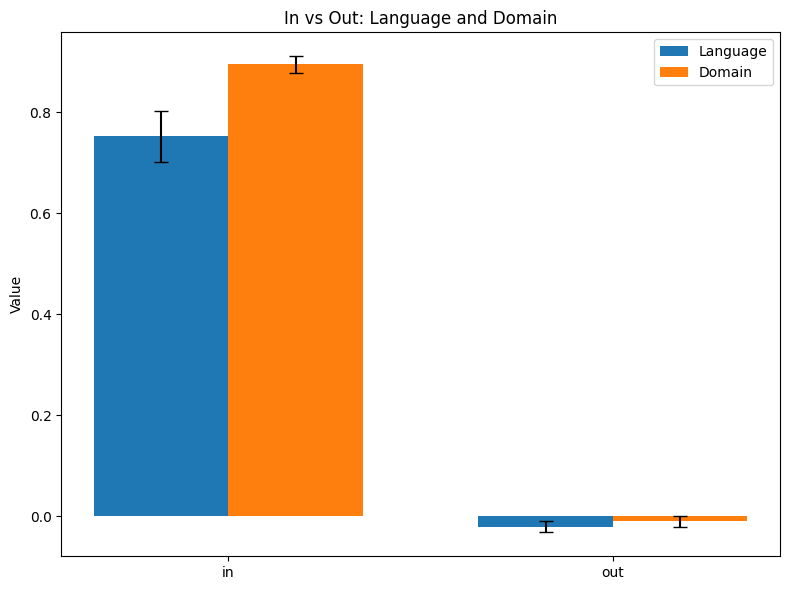

In [6]:
import matplotlib.pyplot as plt


# Categories
categories = ['in', 'out']
x = np.arange(len(categories))
width = 0.35  # bar width

# Means and standard errors
means_language = [agg[cat]['language'][0] for cat in categories]
errors_language = [agg[cat]['language'][1] for cat in categories]

means_domain = [agg[cat]['domain'][0] for cat in categories]
errors_domain = [agg[cat]['domain'][1] for cat in categories]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, means_language, width, yerr=errors_language, label='Language', capsize=5)
ax.bar(x + width/2, means_domain, width, yerr=errors_domain, label='Domain', capsize=5)

# Formatting
ax.set_ylabel('Value')
ax.set_title('In vs Out: Language and Domain')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
results["baseline"]

{'start_en': {'eval_en': 0.98,
  'eval_de': 0.0,
  'eval_city': 0.26,
  'eval_disease': 0.08},
 'start_de': {'eval_en': 0.12,
  'eval_de': 0.92,
  'eval_city': 0.0,
  'eval_disease': 0.06},
 'disease': {'eval_en': 1.0,
  'eval_de': 0.0,
  'eval_city': 0.04,
  'eval_disease': 0.84},
 'city': {'eval_en': 0.96,
  'eval_de': 0.04,
  'eval_city': 0.38,
  'eval_disease': 0.02}}

In [8]:
results.keys()

dict_keys(['baseline', 'en_short_city_de_long_disease', 'en_long_city_de_short_disease', 'en_short_disease_de_long_city', 'en_long_disease_de_short_city'])

In [9]:
results["en_short_city_de_long_disease"]

{'start_en': {'eval_en': 0.98,
  'eval_de': 0.04,
  'eval_city': 0.94,
  'eval_disease': 0.04},
 'start_de': {'eval_en': 0.02,
  'eval_de': 1.0,
  'eval_city': 0.0,
  'eval_disease': 1.0},
 'disease': {'eval_en': 0.2,
  'eval_de': 0.84,
  'eval_city': 0.06,
  'eval_disease': 0.9},
 'city': {'eval_en': 1.0,
  'eval_de': 0.0,
  'eval_city': 0.98,
  'eval_disease': 0.0}}